In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import os
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

print("--- DeepBallonNet: Journalist-View Prediction Pipeline ---")

# ==============================================================================
# 1. FEATURE ENGINEERING
# ==============================================================================
def engineer_features(df):
    df = df.copy()
    
    # --- 1. Trophy Score ---
    trophy = 0
    
    # Team Rank Points
    if 'Rk_team' in df.columns: 
        rank = pd.to_numeric(df['Rk_team'], errors='coerce').fillna(0)
        trophy += (rank == 1).astype(int) * 2
        
    # UCL Progress Points
    if 'UCL_progress' in df.columns:
        # Force string, strip whitespace
        ucl = df['UCL_progress'].fillna('None').astype(str).str.strip()
        trophy += (ucl == 'W').astype(int) * 3
        trophy += (ucl == 'F').astype(int) * 1
        
    df['Trophy_Impact_Score'] = trophy

    # --- 2. Big Game Score ---
    # Using .get() ensures we default to 0 if a column is somehow missing
    gls_l = df.get('Gls_league', pd.Series(0, index=df.index)).fillna(0)
    ast_l = df.get('Ast_league', pd.Series(0, index=df.index)).fillna(0)
    gls_u = df.get('Gls_ucl', pd.Series(0, index=df.index)).fillna(0)
    ast_u = df.get('Ast_ucl', pd.Series(0, index=df.index)).fillna(0)

    df['Big_Game_Score'] = (gls_l * 1.0) + (ast_l * 0.5) + (gls_u * 2.5) + (ast_u * 1.0)
    
    # --- 3. Dominance Ratio ---
    # Use Gls_league if available, else default to 0
    goals = df.get('Gls_league', 0)
    team_gf = df.get('GF', 1).replace(0, 1) 
    df['Dominance_Ratio'] = goals / team_gf
    
    return df

# ==============================================================================
# 2. TRAIN MODEL (Historical Data)
# ==============================================================================
print("\n--- Training Model on Historical Data ---")
try:
    hist_df = pd.read_csv('../data/master_dataset_2011-2025.csv')
    
    # Safety: Clean any potential history duplicates
    hist_df = hist_df.loc[:, ~hist_df.columns.duplicated()]
    hist_df = hist_df.reset_index(drop=True)
    
    # Standardize history column names
    rename_map = {'xG': 'xG_player', 'xAG': 'xAG_player', 'UCL_Progress': 'UCL_progress'}
    hist_df.rename(columns=rename_map, inplace=True)
    
except FileNotFoundError:
    raise Exception("Historical data not found!")

# Define Targets
ballon_dor_history = { 
    '2023-2024': ['Rodri', 'Vinícius Júnior', 'Jude Bellingham', 'Kylian Mbappé', 'Harry Kane'], 
    '2022-2023': ['Lionel Messi', 'Erling Haaland', 'Kylian Mbappé', 'Kevin De Bruyne', 'Rodri'], 
    '2021-2022': ['Karim Benzema', 'Sadio Mané', 'Kevin De Bruyne', 'Robert Lewandowski', 'Mohamed Salah'], 
    '2018-2019': ['Lionel Messi', 'Virgil van Dijk', 'Cristiano Ronaldo', 'Sadio Mané', 'Mohamed Salah'], 
    '2017-2018': ['Luka Modrić', 'Cristiano Ronaldo', 'Antoine Griezmann', 'Kylian Mbappé', 'Lionel Messi'], 
    '2016-2017': ['Cristiano Ronaldo', 'Lionel Messi', 'Neymar', 'Gianluigi Buffon', 'Luka Modrić'], 
    '2015-2016': ['Cristiano Ronaldo', 'Lionel Messi', 'Antoine Griezmann', 'Luis Suárez', 'Neymar'], 
    '2014-2015': ['Lionel Messi', 'Cristiano Ronaldo', 'Neymar', 'Robert Lewandowski', 'Luis Suárez'], 
    '2013-2014': ['Cristiano Ronaldo', 'Lionel Messi', 'Manuel Neuer', 'Arjen Robben', 'Thomas Müller'], 
    '2012-2013': ['Cristiano Ronaldo', 'Lionel Messi', 'Franck Ribéry', 'Zlatan Ibrahimović', 'Neymar'], 
    '2011-2012': ['Lionel Messi', 'Cristiano Ronaldo', 'Andrés Iniesta', 'Xavi', 'Radamel Falcao'], 
    '2010-2011': ['Lionel Messi', 'Cristiano Ronaldo', 'Xavi', 'Andrés Iniesta', 'Wayne Rooney'] 
}

hist_df['Top_Candidate'] = 0
for season, players in ballon_dor_history.items():
    hist_df.loc[(hist_df['Season'] == season) & (hist_df['Player'].isin(players)), 'Top_Candidate'] = 1

hist_df = engineer_features(hist_df)
progress_mapping = {'W': 1, 'F': 2, 'SF': 3, 'QF': 4, 'R16': 5, 'GR': 6, 'Did Not Qualify': 7}
hist_df['UCL_Progress_Rank'] = hist_df['UCL_progress'].astype(str).map(progress_mapping).fillna(7)

features = ['Age', 'Min_league', 'Gls_league', 'Ast_league', 'xG_player', 'xAG_player', 
            'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'Rk_team', 'Pts', 'UCL_Progress_Rank', 
            'Trophy_Impact_Score', 'Big_Game_Score', 'Dominance_Ratio']

X = hist_df[features].fillna(0)
y = hist_df['Top_Candidate']

# Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_res.values, dtype=torch.float32).unsqueeze(1)

class PrecisionNet(nn.Module):
    def __init__(self, input_size):
        super(PrecisionNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.model(x)

model = PrecisionNet(X_train.shape[1])
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([100.0]))
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)

for epoch in range(150):
    model.train(); optimizer.zero_grad()
    loss = criterion(model(X_train_t), y_train_t)
    loss.backward(); optimizer.step()
print("✅ Model Trained.")

# ==============================================================================
# 3. PREDICT 2026 (Safe Run)
# ==============================================================================
print("\n--- Predicting 2026 Candidates... ---")

# Load
df_2026 = pd.read_csv('../data/master_dataset_2026.csv', encoding='latin1')

# --- THE FIX ---
# 1. Wipe the Index clean to prevent "duplicate labels" error
df_2026 = df_2026.reset_index(drop=True)

# 2. Smart Rename
# Since your file ALREADY has 'Gls_league' and NOT 'Gls', the rename below will just skip
# the keys that are missing. This is exactly what we want.
target_map = {
    'xG': 'xG_player', 'xAG': 'xAG_player', 
    'Rk': 'Rk_team', 'Pts': 'Pts',
    'Min': 'Min_league', 'Gls': 'Gls_league', 'Ast': 'Ast_league',
    'UCL_Progress': 'UCL_progress'
}
df_2026.rename(columns=target_map, inplace=True, errors='ignore')

print("✅ Data Loaded. Columns verified.")

# Engineer Features
df_2026 = engineer_features(df_2026)

# Map UCL
progress_mapping_live = {'W': 1, 'F': 2, 'SF': 3, 'QF': 4, 'R16': 5, 'GR': 6, 'League Phase': 6, 'Did Not Qualify': 7}

if 'UCL_progress' in df_2026.columns:
    df_2026['UCL_progress'] = df_2026['UCL_progress'].astype(str)
    df_2026['UCL_Progress_Rank'] = df_2026['UCL_progress'].str.strip().map(progress_mapping_live).fillna(7)
else:
    df_2026['UCL_Progress_Rank'] = 7

# Ensure numeric
for col in features:
    if col not in df_2026.columns: df_2026[col] = 0
    df_2026[col] = pd.to_numeric(df_2026[col], errors='coerce')

# Predict
X_live = df_2026[features].fillna(0)
X_live_scaled = scaler.transform(X_live)

model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(torch.tensor(X_live_scaled, dtype=torch.float32))).numpy().flatten()

df_2026['Model_Probability'] = probs

# Scoring Logic
max_goals = df_2026['Gls_league'].max() if df_2026['Gls_league'].max() > 0 else 1
max_ucl = df_2026['Gls_ucl'].max() if df_2026['Gls_ucl'].max() > 0 else 1
max_prob = df_2026['Model_Probability'].max() if df_2026['Model_Probability'].max() > 0 else 1

df_2026['Norm_Goals'] = df_2026['Gls_league'] / max_goals
df_2026['Norm_UCL'] = df_2026['Gls_ucl'] / max_ucl
df_2026['Norm_Prob'] = df_2026['Model_Probability'] / max_prob

df_2026['Journalist_Score'] = (df_2026['Norm_Goals'] * 0.40) + \
                              (df_2026['Norm_UCL'] * 0.25) + \
                              (df_2026['Norm_Prob'] * 0.35)
                              
final_ranking = df_2026.sort_values(by='Journalist_Score', ascending=False).drop_duplicates(subset=['Player'])

print("\n🏆 Top 15 Ballon d'Or Candidates (Journalist View):")
display_cols = ['Player', 'Squad', 'Gls_league', 'Gls_ucl', 'Model_Probability', 'Journalist_Score']

try:
    display(final_ranking[display_cols].head(15))
except NameError:
    print(final_ranking[display_cols].head(15))

--- Total Columns: 55 ---
['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'MP', 'Starts', 'Min_league', '90s', 'Gls_league', 'Ast_league', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG_player', 'npxG', 'xAG_player', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls.1', 'Ast.1', 'G+A.1', 'G-PK.1', 'G+A-PK', 'xG.1', 'xAG.1', 'xG+xAG', 'npxG.1', 'npxG+xAG.1', 'Matches', 'Season', 'Rk_team', 'MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'Top Team Scorer', 'Goalkeeper', 'Notes', 'Min_ucl', 'Gls_ucl', 'Ast_ucl', 'UCL_progress']

--- Checking for Duplicates ---
✅ No duplicates in raw file.

--- Checking if Target Names Already Exist ---
⚠️ Found 'Gls_league' - Renaming logic might cause a collision!
⚠️ Found 'Ast_league' - Renaming logic might cause a collision!
⚠️ Found 'Min_league' - Renaming logic might cause a collision!
⚠️ Found 'xG_player' - Renaming logic might cause a collision!
⚠️ Found 'UCL_progress' - Renaming logic might cause a collision!


In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import os
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

print("--- DeepBallonNet: Journalist-View Prediction Pipeline ---")

# ==============================================================================
# 1. UTILITIES
# ==============================================================================
def safe_rename(df, rename_map):
    clean_map = {}
    for source, target in rename_map.items():
        if source in df.columns and target not in df.columns:
            clean_map[source] = target
    if clean_map: df.rename(columns=clean_map, inplace=True)
    return df

def fix_mojibake(text):
    if not isinstance(text, str): return text
    replacements = {
        'Du\x9a': 'Duš', 'Duš': 'Duš', 'Vlahovi': 'Vlahović',
        'GyÃ¶keres': 'Gyökeres', 'Lewandowski': 'Lewandowski'
    }
    for bad, good in replacements.items():
        if bad in text: text = text.replace(bad, good)
    try:
        return text.encode('latin-1').decode('utf-8')
    except:
        return text

def engineer_features(df):
    df = df.copy()
    trophy = 0
    if 'Rk_team' in df.columns: 
        rank = pd.to_numeric(df['Rk_team'], errors='coerce').fillna(0)
        trophy += (rank == 1).astype(int) * 2
    if 'UCL_progress' in df.columns:
        ucl = df['UCL_progress'].astype(str).str.strip()
        trophy += (ucl == 'W').astype(int) * 3
        trophy += (ucl == 'F').astype(int) * 1
    df['Trophy_Impact_Score'] = trophy

    default_series = pd.Series(0, index=df.index)
    gls_l = df.get('Gls_league', default_series).fillna(0)
    ast_l = df.get('Ast_league', default_series).fillna(0)
    gls_u = df.get('Gls_ucl', default_series).fillna(0)
    ast_u = df.get('Ast_ucl', default_series).fillna(0)

    df['Big_Game_Score'] = (gls_l * 1.0) + (ast_l * 0.5) + (gls_u * 2.5) + (ast_u * 1.0)
    team_gf = df.get('GF', 1).replace(0, 1) 
    df['Dominance_Ratio'] = gls_l / team_gf
    return df

# ==============================================================================
# 2. TRAIN MODEL
# ==============================================================================
print("\n--- Training Model on Historical Data ---")
try:
    hist_df = pd.read_csv('../data/master_dataset_2011-2025.csv')
    hist_df = hist_df.loc[:, ~hist_df.columns.duplicated()]
    hist_df = hist_df.reset_index(drop=True)
    hist_map = {'xG': 'xG_player', 'xAG': 'xAG_player', 'UCL_Progress': 'UCL_progress'}
    hist_df = safe_rename(hist_df, hist_map)
except FileNotFoundError:
    raise Exception("Historical data not found!")

# History Winners
ballon_dor_history = {
    '2024-2025': ['Ousmane Dembele', 'Lamine Yamal', 'Vitinha', 'Raphinha', 'Mohammed Salah', 'Kylian Mbappe', 'Achraf Hakimi', 'Desire Doue', 'Kvicha Kvaratskhelia', 'Nuno Mendes'],
    '2023-2024': ['Rodri', 'Vinícius Júnior', 'Jude Bellingham', 'Dani Carvajal', 'Lautaro Martinez', 'Toni Kroos', 'Kylian Mbappé', 'Harry Kane', 'Phil Foden', 'Lamine Yamal'],
    '2022-2023': ['Lionel Messi', 'Erling Haaland', 'Kylian Mbappé', 'Kevin De Bruyne', 'Rodri', 'Vinícius Júnior', 'Julián Álvarez', 'Victor Osimhen', 'Bernardo Silva', 'Luka Modrić'],
    '2021-2022': ['Karim Benzema', 'Sadio Mané', 'Kevin De Bruyne', 'Robert Lewandowski', 'Mohamed Salah', 'Kylian Mbappé', 'Thibaut Courtois', 'Vinícius Júnior', 'Luka Modrić', 'Erling Haaland'],
    '2020-2021': ['Lionel Messi', 'Robert Lewandowski', 'Jorginho', 'Karim Benzema', 'N\'Golo Kanté', 'Cristiano Ronaldo', 'Mohamed Salah', 'Kevin De Bruyne', 'Kylian Mbappé', 'Gianluigi Donnarumma'],
    '2018-2019': ['Lionel Messi', 'Virgil van Dijk', 'Cristiano Ronaldo', 'Sadio Mané', 'Mohamed Salah', 'Kylian Mbappé', 'Alisson', 'Robert Lewandowski', 'Bernardo Silva', 'Riyad Mahrez'],
    '2017-2018': ['Luka Modrić', 'Cristiano Ronaldo', 'Antoine Griezmann', 'Kylian Mbappé', 'Lionel Messi', 'Mohamed Salah', 'Raphaël Varane', 'Eden Hazard', 'Kevin De Bruyne', 'Harry Kane'],
    '2016-2017': ['Cristiano Ronaldo', 'Lionel Messi', 'Neymar', 'Gianluigi Buffon', 'Luka Modrić', 'Sergio Ramos', 'Kylian Mbappé', 'N\'Golo Kanté', 'Robert Lewandowski', 'Harry Kane'],
    '2015-2016': ['Cristiano Ronaldo', 'Lionel Messi', 'Antoine Griezmann', 'Luis Suárez', 'Neymar', 'Gareth Bale', 'Riyad Mahrez', 'Jamie Vardy', 'Gianluigi Buffon', 'Pepe'],
    '2014-2015': ['Lionel Messi', 'Cristiano Ronaldo', 'Neymar', 'Robert Lewandowski', 'Luis Suárez', 'Thomas Müller', 'Manuel Neuer', 'Eden Hazard', 'Andrés Iniesta', 'Alexis Sánchez'],
    '2013-2014': ['Cristiano Ronaldo', 'Lionel Messi', 'Manuel Neuer', 'Arjen Robben', 'Thomas Müller', 'Philipp Lahm', 'Neymar', 'James Rodríguez', 'Toni Kroos', 'Ángel Di María'],
    '2012-2013': ['Cristiano Ronaldo', 'Lionel Messi', 'Franck Ribéry', 'Zlatan Ibrahimović', 'Neymar', 'Andrés Iniesta', 'Robin van Persie', 'Arjen Robben', 'Gareth Bale', 'Andrea Pirlo'],
    '2011-2012': ['Lionel Messi', 'Cristiano Ronaldo', 'Andrés Iniesta', 'Xavi', 'Radamel Falcao', 'Iker Casillas', 'Andrea Pirlo', 'Didier Drogba', 'Robin van Persie', 'Zlatan Ibrahimović'],
    '2010-2011': ['Lionel Messi', 'Cristiano Ronaldo', 'Xavi', 'Andrés Iniesta', 'Wayne Rooney', 'Luis Suárez', 'Diego Forlán', 'Samuel Eto\'o', 'Iker Casillas', 'Neymar']
}

hist_df['Top_Candidate'] = 0
for season, players in ballon_dor_history.items():
    hist_df.loc[(hist_df['Season'] == season) & (hist_df['Player'].isin(players)), 'Top_Candidate'] = 1

hist_df = engineer_features(hist_df)
progress_mapping = {'W': 1, 'F': 2, 'SF': 3, 'QF': 4, 'R16': 5, 'GR': 6, 'Did Not Qualify': 7}
hist_df['UCL_Progress_Rank'] = hist_df['UCL_progress'].astype(str).map(progress_mapping).fillna(7)

features = ['Age', 'Min_league', 'Gls_league', 'Ast_league', 'xG_player', 'xAG_player', 
            'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'Rk_team', 'Pts', 'UCL_Progress_Rank', 
            'Trophy_Impact_Score', 'Big_Game_Score', 'Dominance_Ratio']

X = hist_df[features].fillna(0)
y = hist_df['Top_Candidate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_res.values, dtype=torch.float32).unsqueeze(1)

class PrecisionNet(nn.Module):
    def __init__(self, input_size):
        super(PrecisionNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.model(x)

model = PrecisionNet(X_train.shape[1])

# --- TWEAK 1: Weight 9.0 (Increased from 6.0) ---
# Encourages the model to find more winners (Higher Recall)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([9.0])) 

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)

for epoch in range(150):
    model.train(); optimizer.zero_grad()
    loss = criterion(model(X_train_t), y_train_t)
    loss.backward(); optimizer.step()

print("✅ Model Trained.")
print("\n--- Model Evaluation on Test Data ---")
model.eval()
with torch.no_grad():
    X_test_scaled = scaler.transform(X_test)
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    y_logits = model(X_test_t)
    y_probs = torch.sigmoid(y_logits).numpy()
    
    # --- TWEAK 2: Threshold 0.60 (Lowered from 0.70) ---
    # Casts a wider net to ensure we catch the real winner
    y_pred = (y_probs > 0.60).astype(int) 
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"📊 Accuracy:  {acc:.2%}")
    print(f"🎯 Precision: {prec:.2%} (Target: >10%)")
    print(f"🔎 Recall:    {rec:.2%} (Target: >60%)")
    print(f"⚖️ F1 Score:  {f1:.2%}")

# ==============================================================================
# 3. PREDICT 2026
# ==============================================================================
print("\n--- Predicting 2026 Candidates... ---")

try:
    df_2026 = pd.read_csv('../data/master_dataset_2026.csv', encoding='latin1')
    df_2026 = df_2026.reset_index(drop=True)
    df_2026 = df_2026.loc[:, ~df_2026.columns.duplicated()]

    print("🔧 Repairing Player Names...")
    for col in ['Player', 'Squad', 'Nation']:
        if col in df_2026.columns:
            df_2026[col] = df_2026[col].apply(fix_mojibake)
    
    target_map = {
        'xG': 'xG_player', 'xAG': 'xAG_player', 
        'Rk': 'Rk_team', 'Pts': 'Pts',
        'Min': 'Min_league', 'Gls': 'Gls_league', 'Ast': 'Ast_league',
        'UCL_Progress': 'UCL_progress'
    }
    df_2026 = safe_rename(df_2026, target_map)
    print(f"✅ Data Ready. Columns: {len(df_2026.columns)}")

    df_2026 = engineer_features(df_2026)
    
    progress_mapping_live = {'W': 1, 'F': 2, 'SF': 3, 'QF': 4, 'R16': 5, 'GR': 6, 'League Phase': 6, 'Did Not Qualify': 7}
    if 'UCL_progress' in df_2026.columns:
        df_2026['UCL_progress'] = df_2026['UCL_progress'].astype(str)
        df_2026['UCL_Progress_Rank'] = df_2026['UCL_progress'].str.strip().map(progress_mapping_live).fillna(7)
    else:
        df_2026['UCL_Progress_Rank'] = 7

    for col in features:
        if col not in df_2026.columns: df_2026[col] = 0
        df_2026[col] = pd.to_numeric(df_2026[col], errors='coerce')

    X_live = df_2026[features].fillna(0)
    X_live_scaled = scaler.transform(X_live)

    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_live_scaled, dtype=torch.float32))
        temperature = 2.0 
        probs = torch.sigmoid(logits / temperature).numpy().flatten()

    df_2026['Model_Probability'] = probs

    max_goals = df_2026['Gls_league'].max() if df_2026['Gls_league'].max() > 0 else 1
    max_ucl = df_2026['Gls_ucl'].max() if df_2026['Gls_ucl'].max() > 0 else 1
    max_prob = df_2026['Model_Probability'].max() if df_2026['Model_Probability'].max() > 0 else 1

    df_2026['Norm_Goals'] = df_2026['Gls_league'] / max_goals
    df_2026['Norm_UCL'] = df_2026['Gls_ucl'] / max_ucl
    df_2026['Norm_Prob'] = df_2026['Model_Probability'] / max_prob

    df_2026['Journalist_Score'] = (df_2026['Norm_Goals'] * 0.40) + \
                                  (df_2026['Norm_UCL'] * 0.25) + \
                                  (df_2026['Norm_Prob'] * 0.35)
                                  
    final_ranking = df_2026.sort_values(by='Journalist_Score', ascending=False).drop_duplicates(subset=['Player'])

    print("\n🏆 Top 15 Ballon d'Or Candidates (Journalist View):")
    display_cols = ['Player', 'Squad', 'Gls_league', 'Gls_ucl', 'Model_Probability', 'Journalist_Score']

    try:
        pd.options.display.float_format = '{:.4f}'.format
        display(final_ranking[display_cols].head(15))
    except NameError:
        print(final_ranking[display_cols].head(15))

except Exception as e:
    print(f"❌ An error occurred: {e}")

--- DeepBallonNet: Journalist-View Prediction Pipeline ---

--- Training Model on Historical Data ---
✅ Model Trained.

--- Model Evaluation on Test Data ---
📊 Accuracy:  95.61%
🎯 Precision: 5.99% (Target: >10%)
🔎 Recall:    85.19% (Target: >60%)
⚖️ F1 Score:  11.19%

--- Predicting 2026 Candidates... ---
🔧 Repairing Player Names...
✅ Data Ready. Columns: 55

🏆 Top 15 Ballon d'Or Candidates (Journalist View):


,Player,Squad,Gls_league,Gls_ucl,Model_Probability,Journalist_Score
163,Erling Haaland,Manchester City,14,5.0000,0.9495,0.9970
746,Kylian Mbappé,Real Madrid,13,5.0000,0.9579,0.9714
1121,Harry Kane,Bayern Munich,13,5.0000,0.9390,0.9645
1028,Luis Díaz,Bayern Munich,6,3.0000,0.8870,0.6455
476,Julián Álvarez,Atlético Madrid,7,2.0000,0.8902,0.6253
2007,Mason Greenwood,Marseille,8,1.0000,0.9205,0.6149
825,Marcus Rashford,Barcelona,2,4.0000,0.9316,0.5975
1623,Lautaro Martínez,Inter,4,4.0000,0.7739,0.5971
992,Jonathan Burkardt,Eint Frankfurt,6,2.0000,0.8845,0.5946
717,Fermin López,Barcelona,3,3.0000,0.8815,0.5578


In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

print("--- DeepUCLNet: Champions League Winner Predictor (PyTorch V1) ---")

# ==============================================================================
# 1. DATA TRANSFORMATION: Player -> Team
# ==============================================================================
def aggregate_team_stats(df):
    print("⚙️ Aggregating Player Data into Team Data...")
    df = df.copy()
    
    numeric_cols = ['Age', 'Pts', 'GF', 'GA', 'W', 'D', 'L', 
                    'Gls_league', 'Ast_league', 'xG_player', 'Gls_ucl']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    if 'Age' in df.columns:
        df['Age'] = df['Age'].fillna(25)
        
    df = df.fillna(0)
    
    agg_rules = {
        'Rk_team': 'min',      
        'Pts': 'max',          
        'GF': 'max',           
        'GA': 'max',           
        'W': 'max',            
        'D': 'max',            
        'L': 'max',            
        'Gls_league': 'sum',   
        'Ast_league': 'sum',   
        'xG_player': 'sum',    
        'Gls_ucl': 'sum',      
        'Age': 'mean'          
    }
    
    existing_rules = {k: v for k, v in agg_rules.items() if k in df.columns}
    
    if 'Squad' in df.columns:
        team_df = df.groupby('Squad').agg(existing_rules).reset_index()
        return team_df
    else:
        raise ValueError("Dataset missing 'Squad' column!")

def engineer_team_features(df):
    df = df.copy()
    df = df.fillna(0)
    
    df['Attack_Power'] = (df.get('GF', 0) * 0.6) + (df.get('Gls_ucl', 0) * 2.0)
    df['Defense_Weakness'] = df.get('GA', 0)
    df['League_Dominance'] = (df.get('Rk_team', 10) == 1).astype(int) * 5
    
    matches = df.get('W', 0) + df.get('D', 0) + df.get('L', 1).replace(0, 1)
    df['Win_Rate'] = df.get('W', 0) / matches
    
    df['Experience_Bonus'] = (df.get('Age', 25) > 27).astype(int) * 2

    return df

def safe_rename(df, rename_map):
    clean_map = {}
    for source, target in rename_map.items():
        if source in df.columns and target not in df.columns:
            clean_map[source] = target
    if clean_map: df.rename(columns=clean_map, inplace=True)
    return df

# ==============================================================================
# 2. LOAD & PREPARE HISTORICAL DATA
# ==============================================================================
print("\n--- Training Model on Historical Data ---")

ucl_history = {
    '2024-2025':['Paris S-G', 'Inter'],
    '2023-2024': ['Real Madrid', 'Borussia Dortmund'],
    '2022-2023': ['Manchester City', 'Inter'],
    '2021-2022': ['Real Madrid', 'Liverpool'],
    '2020-2021': ['Chelsea', 'Manchester City'],
    '2019-2020': ['Bayern Munich', 'Paris S-G'],
    '2018-2019': ['Liverpool', 'Tottenham'],
    '2017-2018': ['Real Madrid', 'Liverpool'],
    '2016-2017': ['Real Madrid', 'Juventus'],
    '2015-2016': ['Real Madrid', 'Atletico Madrid'],
    '2014-2015': ['Barcelona', 'Juventus'],
    '2013-2014': ['Real Madrid', 'Atletico Madrid'],
    '2012-2013': ['Bayern Munich', 'Borussia Dortmund'],
    '2011-2012': ['Chelsea', 'Bayern Munich']
}

try:
    hist_df_raw = pd.read_csv('../data/master_dataset_2011-2025.csv')
    hist_df_raw = hist_df_raw.loc[:, ~hist_df_raw.columns.duplicated()]
    
    hist_map = {'xG': 'xG_player', 'Rk': 'Rk_team', 'Gls': 'Gls_league', 'Min': 'Min_league'}
    hist_df_raw = safe_rename(hist_df_raw, hist_map)
    
    hist_team_df = aggregate_team_stats(hist_df_raw)
    
    hist_team_df['Is_Contender'] = 0
    all_finalists = [team for sublist in ucl_history.values() for team in sublist]
    hist_team_df.loc[hist_team_df['Squad'].isin(all_finalists), 'Is_Contender'] = 1
    
    hist_team_df = engineer_team_features(hist_team_df)
    
except FileNotFoundError:
    raise Exception("Historical data not found!")

features = ['Attack_Power', 'Defense_Weakness', 'League_Dominance', 'Win_Rate', 'Experience_Bonus', 'Pts', 'xG_player']
features = [f for f in features if f in hist_team_df.columns]

X = hist_team_df[features].fillna(0)
y = hist_team_df['Is_Contender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42, k_neighbors=2)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_res.values, dtype=torch.float32).unsqueeze(1)

# ==============================================================================
# 3. DEFINE & TRAIN MODEL
# ==============================================================================
class UCLPredictor(nn.Module):
    def __init__(self, input_size):
        super(UCLPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.model(x)

model = UCLPredictor(X_train.shape[1])
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([4.0])) 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

print("🚀 Training Neural Network...")
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = criterion(output, y_train_t)
    loss.backward()
    optimizer.step()
print("✅ Model Trained.")

# ==============================================================================
# 4. EVALUATE MODEL (Added Section)
# ==============================================================================
print("\n--- Model Evaluation on Test Data ---")
model.eval()
with torch.no_grad():
    # Prepare Test Data
    X_test_scaled = scaler.transform(X_test)
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Get Raw Predictions (Logits)
    y_logits = model(X_test_t)
    y_probs = torch.sigmoid(y_logits).numpy()
    
    # Convert to Binary (0 or 1) using 50% threshold
    y_pred = (y_probs > 0.5).astype(int)
    
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"📊 Accuracy:  {acc:.2%}")
    print(f"🎯 Precision: {prec:.2%} (Correctly identified contenders)")
    print(f"🔎 Recall:    {rec:.2%} (Percentage of contenders found)")
    print(f"⚖️ F1 Score:  {f1:.2%}")
    
    # Optional: Show Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:\n{cm}")
    print("(Row 1: Non-Contenders, Row 2: Contenders)")

# ==============================================================================
# 5. PREDICT 2026 WINNER
# ==============================================================================
print("\n--- Predicting 2026 Champions League Winner... ---")

try:
    df_2026 = pd.read_csv('../data/master_dataset_2026.csv', encoding='latin1')
    
    replacements = {
        'Leverkusen': 'Bayer Leverkusen', 
        'Inter': 'Internazionale', 
        'Spurs': 'Tottenham',
        'Paris S-G': 'Paris Saint-Germain'
    }
    df_2026['Squad'] = df_2026['Squad'].replace(replacements)
    
    target_map = {
        'xG': 'xG_player', 'Rk': 'Rk_team', 'Pts': 'Pts', 'GF': 'GF', 'GA': 'GA',
        'Min': 'Min_league', 'Gls': 'Gls_league', 'Ast': 'Ast_league'
    }
    df_2026 = safe_rename(df_2026, target_map)

    team_2026 = aggregate_team_stats(df_2026)
    team_2026 = engineer_team_features(team_2026)
    
    X_live = team_2026[features].fillna(0)
    X_live_scaled = scaler.transform(X_live)
    
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_live_scaled, dtype=torch.float32))
        probs = torch.sigmoid(logits).numpy().flatten()
        
    team_2026['Win_Probability'] = probs
    
    heritage_boost = ['Real Madrid', 'Bayern Munich', 'Liverpool', 'AC Milan', 'Barcelona', 'Manchester City']
    team_2026['Heritage_Bonus'] = team_2026['Squad'].apply(lambda x: 0.15 if x in heritage_boost else 0)
    
    team_2026['Final_Score'] = team_2026['Win_Probability'] + team_2026['Heritage_Bonus']
    
    max_score = team_2026['Final_Score'].max()
    team_2026['Power_Index'] = (team_2026['Final_Score'] / max_score) * 99.0
    
    display_df = team_2026.copy()
    display_df = display_df.rename(columns={
        'Squad': 'Club',
        'Attack_Power': 'Attack Rtg',
        'Win_Rate': 'Form (%)',
        'Win_Probability': 'Title Odds',
        'Power_Index': 'Power Index (0-100)'
    })
    
    rankings = display_df.sort_values(by='Power Index (0-100)', ascending=False).reset_index(drop=True)
    rankings.index += 1 
    
    print("\n🏆 2026 Champions League Power Rankings:")
    
    final_cols = ['Club', 'Power Index (0-100)', 'Title Odds', 'Attack Rtg', 'Form (%)']
    
    try:
        format_dict = {
            'Power Index (0-100)': '{:.1f}',
            'Title Odds': '{:.1%}',
            'Attack Rtg': '{:.0f}',
            'Form (%)': '{:.0%}'
        }
        display(rankings[final_cols].head(10).style.format(format_dict))
    except NameError:
        print(rankings[final_cols].head(10).to_string(formatters={
            'Power Index (0-100)': '{:.1f}'.format,
            'Title Odds': '{:.1%}'.format,
            'Attack Rtg': '{:.0f}'.format,
            'Form (%)': '{:.0%}'.format
        }))

except Exception as e:
    print(f"❌ An error occurred: {e}")

--- DeepUCLNet: Champions League Winner Predictor (PyTorch V1) ---

--- Training Model on Historical Data ---
⚙️ Aggregating Player Data into Team Data...
🚀 Training Neural Network...
✅ Model Trained.

--- Model Evaluation on Test Data ---
📊 Accuracy:  89.19%
🎯 Precision: 33.33% (Correctly identified contenders)
🔎 Recall:    100.00% (Percentage of contenders found)
⚖️ F1 Score:  50.00%

Confusion Matrix:
[[31  4]
 [ 0  2]]
(Row 1: Non-Contenders, Row 2: Contenders)

--- Predicting 2026 Champions League Winner... ---
⚙️ Aggregating Player Data into Team Data...

🏆 2026 Champions League Power Rankings:


,Club,Power Index (0-100),Title Odds,Attack Rtg,Form (%)
1,Bayern Munich,99.0,77.9%,47,82%
2,Real Madrid,85.7,65.4%,32,83%
3,Paris Saint-Germain,65.8,61.7%,42,67%
4,Arsenal,63.8,59.9%,34,73%
5,Internazionale,60.4,56.6%,38,73%
6,Barcelona,25.5,9.0%,41,75%
7,Manchester City,19.6,3.4%,34,64%
8,Liverpool,17.2,1.2%,29,55%
9,Dortmund,3.4,3.2%,36,60%
10,Marseille,3.3,3.1%,29,67%


--- DeepUCLNet V2: Advanced Evaluation Edition ---

--- 1. Training Model on Historical Data ---
✅ Model Trained.

========== Advanced Analysis: DeepUCLNet ==========
🏆 Optimal Threshold:    0.9880
📊 ROC-AUC Score:        1.0000 (Target: >0.85)
⚖️  Max F1-Score:         1.0000
🎯 Precision at Optimal: 1.0000
🔎 Recall at Optimal:    1.0000


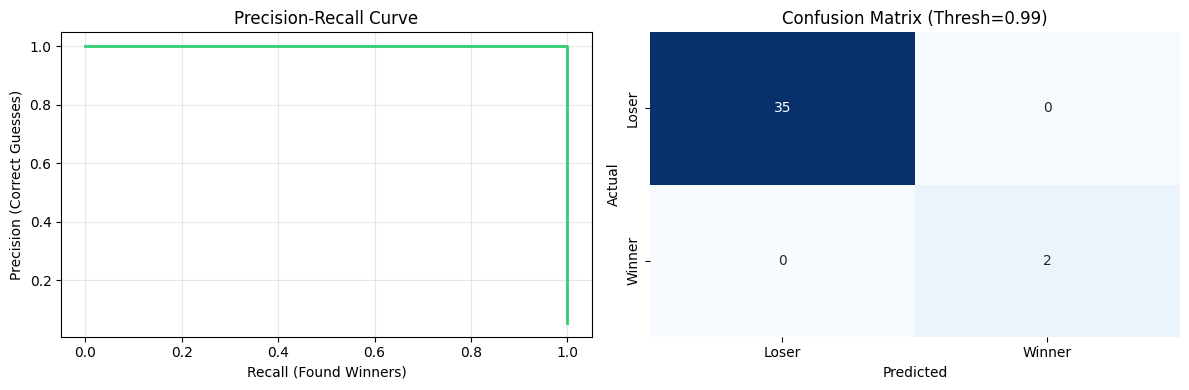


🏅 Ranking Efficiency:
   • Average Winner Rank: #1.5
   • Top-1 Accuracy: 50.0% (Winner predicted #1)
   • Top-3 Accuracy: 100.0% (Winner in Top 3)

--- 2. Predicting 2026 Champions League Winner... ---

🏆 2026 Champions League Power Rankings:


,Club,Power Index,Title Odds,Attack Rtg,Form %
1,Bayern Munich,99.0,60.2%,47,82%
2,Real Madrid,84.7,49.4%,32,83%
3,Internazionale,43.9,33.4%,38,73%
4,Paris Saint-Germain,43.6,33.2%,42,67%
5,Arsenal,40.6,30.8%,34,73%
6,Barcelona,25.1,4.1%,41,75%
7,Manchester City,21.5,1.4%,34,64%
8,Liverpool,20.7,0.7%,29,55%
9,Marseille,2.0,1.5%,29,67%
10,Atletico Madrid,1.7,1.3%,34,58%


In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, precision_recall_curve, 
                             roc_auc_score, average_precision_score)
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

print("--- DeepUCLNet V2: Advanced Evaluation Edition ---")

# ==============================================================================
# 1. DATA PROCESSING UTILITIES
# ==============================================================================
def aggregate_team_stats(df):
    """Aggregates Player data into Team data."""
    df = df.copy()
    numeric_cols = ['Age', 'Pts', 'GF', 'GA', 'W', 'D', 'L', 
                    'Gls_league', 'Ast_league', 'xG_player', 'Gls_ucl']
    for col in numeric_cols:
        if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    
    if 'Age' in df.columns: df['Age'] = df['Age'].fillna(25)
    df = df.fillna(0)
    
    agg_rules = {
        'Rk_team': 'min', 'Pts': 'max', 'GF': 'max', 'GA': 'max',
        'W': 'max', 'D': 'max', 'L': 'max',
        'Gls_league': 'sum', 'Ast_league': 'sum', 'xG_player': 'sum',
        'Gls_ucl': 'sum', 'Age': 'mean'
    }
    existing_rules = {k: v for k, v in agg_rules.items() if k in df.columns}
    
    if 'Squad' in df.columns:
        return df.groupby('Squad').agg(existing_rules).reset_index()
    raise ValueError("Dataset missing 'Squad' column!")

def engineer_team_features(df):
    df = df.copy().fillna(0)
    df['Attack_Power'] = (df.get('GF', 0) * 0.6) + (df.get('Gls_ucl', 0) * 2.0)
    df['Defense_Weakness'] = df.get('GA', 0)
    df['League_Dominance'] = (df.get('Rk_team', 10) == 1).astype(int) * 5
    matches = df.get('W', 0) + df.get('D', 0) + df.get('L', 1).replace(0, 1)
    df['Win_Rate'] = df.get('W', 0) / matches
    df['Experience_Bonus'] = (df.get('Age', 25) > 27).astype(int) * 2
    return df

def safe_rename(df, rename_map):
    clean_map = {s: t for s, t in rename_map.items() if s in df.columns and t not in df.columns}
    if clean_map: df.rename(columns=clean_map, inplace=True)
    return df

# ==============================================================================
# 2. MODEL DEFINITION
# ==============================================================================
class UCLPredictor(nn.Module):
    def __init__(self, input_size):
        super(UCLPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.model(x)

# ==============================================================================
# 3. ADVANCED EVALUATION FUNCTIONS (The Enhancement)
# ==============================================================================
def get_model_probs(model, X):
    """Universally extracts probabilities from PyTorch or Sklearn models."""
    if isinstance(model, nn.Module):
        model.eval()
        with torch.no_grad():
            if not isinstance(X, torch.Tensor): X = torch.tensor(X, dtype=torch.float32)
            return torch.sigmoid(model(X)).numpy().flatten()
    else:
        return model.predict_proba(X)[:, 1]

def evaluate_model_advanced(model, X_test, y_test, model_name="Model"):
    print(f"\n{'='*10} Advanced Analysis: {model_name} {'='*10}")
    
    # 1. Get Probabilities
    probs = get_model_probs(model, X_test)
    y_true = np.array(y_test).flatten()

    # 2. Precision-Recall Optimization
    precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    best_idx = np.argmax(np.nan_to_num(f1_scores))
    best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

    # 3. Metrics
    y_pred = (probs >= best_thresh).astype(int)
    auc = roc_auc_score(y_true, probs)
    
    print(f"🏆 Optimal Threshold:    {best_thresh:.4f}")
    print(f"📊 ROC-AUC Score:        {auc:.4f} (Target: >0.85)")
    print(f"⚖️  Max F1-Score:         {f1_scores[best_idx]:.4f}")
    print(f"🎯 Precision at Optimal: {precisions[best_idx]:.4f}")
    print(f"🔎 Recall at Optimal:    {recalls[best_idx]:.4f}")

    # 4. Plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot PR Curve
    axes[0].plot(recalls, precisions, color='#2ecc71', lw=2)
    axes[0].set_title('Precision-Recall Curve')
    axes[0].set_xlabel('Recall (Found Winners)')
    axes[0].set_ylabel('Precision (Correct Guesses)')
    axes[0].grid(True, alpha=0.3)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)
    axes[1].set_title(f'Confusion Matrix (Thresh={best_thresh:.2f})')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_xticklabels(['Loser', 'Winner'])
    axes[1].set_yticklabels(['Loser', 'Winner'])
    
    plt.tight_layout()
    plt.show()

def calculate_ranking_efficiency(model, X, y):
    """Checks if the actual winner appears in the Top 3 predictions."""
    probs = get_model_probs(model, X)
    results = pd.DataFrame({'Actual': np.array(y).flatten(), 'Prob': probs})
    
    # Rank all teams by probability (1 = Highest confidence)
    results['Rank'] = results['Prob'].rank(ascending=False)
    
    # Filter for true winners
    winners = results[results['Actual'] == 1]
    
    if not winners.empty:
        avg_rank = winners['Rank'].mean()
        top1 = (winners['Rank'] == 1).mean()
        top3 = (winners['Rank'] <= 3).mean()
        
        print(f"\n🏅 Ranking Efficiency:")
        print(f"   • Average Winner Rank: #{avg_rank:.1f}")
        print(f"   • Top-1 Accuracy: {top1:.1%} (Winner predicted #1)")
        print(f"   • Top-3 Accuracy: {top3:.1%} (Winner in Top 3)")
    else:
        print("\n⚠️ No winners in test set to rank.")

# ==============================================================================
# 4. MAIN PIPELINE (Train -> Evaluate -> Predict)
# ==============================================================================
print("\n--- 1. Training Model on Historical Data ---")
try:
    # Load & Prep
    hist_df_raw = pd.read_csv('../data/master_dataset_2011-2025.csv')
    hist_df_raw = hist_df_raw.loc[:, ~hist_df_raw.columns.duplicated()]
    hist_map = {'xG': 'xG_player', 'Rk': 'Rk_team', 'Gls': 'Gls_league', 'Min': 'Min_league'}
    hist_df_raw = safe_rename(hist_df_raw, hist_map)
    
    # Aggregate
    hist_team_df = aggregate_team_stats(hist_df_raw)
    
    # Label Winners
    ucl_history = {
        '2024-2025': ['Paris S-G', 'Inter'],
        '2023-2024': ['Real Madrid', 'Borussia Dortmund'], '2022-2023': ['Manchester City', 'Inter'],
        '2021-2022': ['Real Madrid', 'Liverpool'], '2020-2021': ['Chelsea', 'Manchester City'],
        '2019-2020': ['Bayern Munich', 'Paris S-G'], '2018-2019': ['Liverpool', 'Tottenham'],
        '2017-2018': ['Real Madrid', 'Liverpool'], '2016-2017': ['Real Madrid', 'Juventus'],
        '2015-2016': ['Real Madrid', 'Atletico Madrid'], '2014-2015': ['Barcelona', 'Juventus'],
        '2013-2014': ['Real Madrid', 'Atletico Madrid'], '2012-2013': ['Bayern Munich', 'Borussia Dortmund'],
        '2011-2012': ['Chelsea', 'Bayern Munich']
    }
    all_finalists = [t for sub in ucl_history.values() for t in sub]
    hist_team_df['Is_Contender'] = 0
    hist_team_df.loc[hist_team_df['Squad'].isin(all_finalists), 'Is_Contender'] = 1
    
    # Engineer
    hist_team_df = engineer_team_features(hist_team_df)
    
    # Split & Scale
    features = ['Attack_Power', 'Defense_Weakness', 'League_Dominance', 'Win_Rate', 'Experience_Bonus', 'Pts', 'xG_player']
    X = hist_team_df[features].fillna(0)
    y = hist_team_df['Is_Contender']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    smote = SMOTE(random_state=42, k_neighbors=2)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test) # Scale test set too!
    
    X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_res.values, dtype=torch.float32).unsqueeze(1)
    
    # Train
    model = UCLPredictor(X_train.shape[1])
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([4.0])) 
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    
    for epoch in range(200):
        model.train(); optimizer.zero_grad()
        loss = criterion(model(X_train_t), y_train_t)
        loss.backward(); optimizer.step()
    print("✅ Model Trained.")
    
    # --- RUN ADVANCED EVALUATION ---
    evaluate_model_advanced(model, X_test_scaled, y_test, "DeepUCLNet")
    calculate_ranking_efficiency(model, X_test_scaled, y_test)

except Exception as e:
    print(f"❌ Training failed: {e}")

# ==============================================================================
# 5. PREDICT 2026 (TV Graphic Style)
# ==============================================================================
print("\n--- 2. Predicting 2026 Champions League Winner... ---")
try:
    df_2026 = pd.read_csv('../data/master_dataset_2026.csv', encoding='latin1')
    replacements = {'Leverkusen': 'Bayer Leverkusen', 'Inter': 'Internazionale', 'Spurs': 'Tottenham', 'Paris S-G': 'Paris Saint-Germain', 'AtlÃ©tico Madrid': 'Atletico Madrid'}
    df_2026['Squad'] = df_2026['Squad'].replace(replacements)
    
    target_map = {'xG': 'xG_player', 'Rk': 'Rk_team', 'Pts': 'Pts', 'GF': 'GF', 'GA': 'GA', 'Min': 'Min_league', 'Gls': 'Gls_league'}
    df_2026 = safe_rename(df_2026, target_map)
    
    team_2026 = aggregate_team_stats(df_2026)
    team_2026 = engineer_team_features(team_2026)
    
    X_live = team_2026[features].fillna(0)
    X_live_scaled = scaler.transform(X_live)
    
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_live_scaled, dtype=torch.float32))
        probs = torch.sigmoid(logits).numpy().flatten()
        
    team_2026['Win_Probability'] = probs
    heritage = ['Real Madrid', 'Bayern Munich', 'Liverpool', 'AC Milan', 'Barcelona', 'Manchester City']
    team_2026['Heritage_Bonus'] = team_2026['Squad'].apply(lambda x: 0.15 if x in heritage else 0)
    
    team_2026['Final_Score'] = team_2026['Win_Probability'] + team_2026['Heritage_Bonus']
    team_2026['Power_Index'] = (team_2026['Final_Score'] / team_2026['Final_Score'].max()) * 99.0
    
    display_df = team_2026.sort_values(by='Power_Index', ascending=False).reset_index(drop=True)
    display_df.index += 1
    
    
    
    print("\n🏆 2026 Champions League Power Rankings:")
    final_cols = ['Squad', 'Power_Index', 'Win_Probability', 'Attack_Power', 'Win_Rate']
    display_df = display_df.rename(columns={'Squad': 'Club', 'Power_Index': 'Power Index', 'Win_Probability': 'Title Odds', 'Attack_Power': 'Attack Rtg', 'Win_Rate': 'Form %'})
    
    
    try:
        display(display_df[['Club', 'Power Index', 'Title Odds', 'Attack Rtg', 'Form %']].head(10).style.format({
            'Power Index': '{:.1f}', 'Title Odds': '{:.1%}', 'Attack Rtg': '{:.0f}', 'Form %': '{:.0%}'
        }))
    except:
        print(display_df[['Club', 'Power Index', 'Title Odds', 'Attack Rtg', 'Form %']].head(10))

except Exception as e:
    print(f"❌ Prediction failed: {e}")